#### Imports

In [1]:
using Plots
using Random
using PolygonOps
using StaticArrays

# Motion Planning Using Convex Optimization

## Model

In [39]:
struct Point
    x::Float64
    y::Float64
end

In [40]:
struct Pose
    position::Point
    orientation::Float64
end

## General Functions

In [2]:
function angleCalculator(dif_x, dif_y)
    ang_aux = 180*atan(dif_y,dif_x)/pi
    println("Raw angle = ", ang_aux)
    if (dif_x >=0 && dif_y >= 0) #top right
        ang_aux = 180 - ang_aux
    elseif (dif_x >=0 && dif_y < 0) #bot right
        ang_aux = abs(ang_aux) + 180
    elseif (dif_x < 0 && dif_y >= 0) #top left
        ang_aux = 180 - ang_aux
    elseif (dif_x < 0 && dif_y < 0) #bot left
        ang_aux = abs(ang_aux) + 180
    end
    println("Corrected angle = ", ang_aux, "\n\n")

    return ang_aux
end

angleCalculator (generic function with 1 method)

## Random Map Generation

### Random Convex Polygon Generation

In [29]:
function GenerateRandomConvexObstacle(numberOfVertices::Int64)
    # Still remains a test for convexity and 
    #keep up with the computation until a convex poligon is found
    
    xCoordinateRandomPoints = []
    yCoordinateRandomPoints = []

    #Generate two lists of random X and Y coordinates
    
    for i in 1:numberOfVertices
        append!(xCoordinateRandomPoints, rand())
        append!(yCoordinateRandomPoints, rand())
        println("X generated: ", xCoordinateRandomPoints[i],", Y generated: ", yCoordinateRandomPoints[i],)
    end

    println("\n\n")

    #Sort them

    sort!(xCoordinateRandomPoints)
    sort!(yCoordinateRandomPoints)
    println("sorting...")

    for i in 1:numberOfVertices
        println("X: ", xCoordinateRandomPoints[i],", Y: ", yCoordinateRandomPoints[i],)
    end

    #Isolate the extreme points
    minimumX = xCoordinateRandomPoints[1]
    maximumX = xCoordinateRandomPoints[numberOfVertices]
    minimumY = yCoordinateRandomPoints[1]
    maximumY = yCoordinateRandomPoints[numberOfVertices]


    xVectors = []
    yVectors = []

    lastTop = minimumX
    lastBot = minimumX;

    println("Separating in 2 chains...")
    for i in 2:numberOfVertices-1
        x = xCoordinateRandomPoints[i];

        if rand(Bool) #Randomly divide the interior points into two chains
            append!(xVectors, x - lastTop) #Extract the vector components
            lastTop = x;
        else 
            append!(xVectors, lastBot - x)
            lastBot = x;
        end
        println("xVectors[", i-1, "] = ", xVectors[i-1])
    end

    append!(xVectors, maximumX - lastTop)
    append!(xVectors, lastBot - maximumX)

    lastLeft = minimumY
    lastRight = minimumY;

    for i in 2:numberOfVertices-1
        y = yCoordinateRandomPoints[i];

        if rand(Bool)
            append!(yVectors, y - lastLeft)
            lastLeft = y;
        else 
            append!(yVectors, lastRight - y)
            lastRight = y;
        end
    end

    append!(yVectors, maximumY - lastLeft)
    append!(yVectors, lastRight - maximumY)

    #Randomly pair up the X- and Y-components
    #Combine the paired up components into vectors
    shuffle(yVectors);

    points = []
    angles = []
    ang_aux = 0
    for i in 1:numberOfVertices       
        println("Point ", i, ": x = ", xVectors[i], " and y = ", yVectors[i])
        angle = angleCalculator(xVectors[i],yVectors[i])
        append!(angles, angle)
    end

    points = MVector.(xVectors,yVectors)

    #Sort the vectors by angle
    order = sortperm(angles)
    points = points[order]

    for p in points
        println(p.x,", ",p.y)
    end

    x = 0
    y = 0
    minPolygonX = 0;
    minPolygonY = 0;
    newPoints_x = []
    newPoints_y = []
    println("generating points:")
    for i in 1:numberOfVertices 
        push!(newPoints_x, x)
        push!(newPoints_y, y)
        println("x = ", newPoints_x[i], ", y = ", newPoints_y[i])
        x += Tuple(points[i])[1];
        y += Tuple(points[i])[2];
        minPolygonX = min(minPolygonX, x)
        minPolygonY = min(minPolygonY, y)
    end
    
    println("\nshift:")
    # xShift = minimumX - minPolygonX;
    # yShift = minimumY - minPolygonY;

    xShift = 0 - minPolygonX;
    yShift = 0 - minPolygonY;
    
    x_points = []
    y_points = []

    println("XShift = ", xShift, ", YShift", yShift)

    println("Shifted points:")
    for i in 1:numberOfVertices 
        push!(x_points, newPoints_x[i] + xShift)
        push!(y_points, newPoints_y[i] + yShift)
        println("x = ", Tuple(points[i])[1], ", y = ", Tuple(points[i])[2])
    end
    
    convexObstacle = SVector.(x_points,y_points)

    return convexObstacle;
end

GenerateRandomConvexObstacle (generic function with 1 method)

X generated: 0.38617738586019223, Y generated: 0.5629808608587974
X generated: 0.29547341948792794, Y generated: 0.3223804531520712
X generated: 0.3193490844636322, Y generated: 0.38854134624985337
X generated: 0.738446421368651, Y generated: 0.8935983442147645
X generated: 0.09091269981416972, Y generated: 0.4157227469090854
X generated: 0.9952263915739372, Y generated: 0.2128462538401512
X generated: 0.0856288699529627, Y generated: 0.9352648198355336
X generated: 0.7507709122399024, Y generated: 0.291132588372661
X generated: 0.8295043896494088, Y generated: 0.7846256299307804
X generated: 0.8119547852462816, Y generated: 0.015858288050844327
X generated: 0.22140266447289259, Y generated: 0.32250819319045554
X generated: 0.14384135868430947, Y generated: 0.29648065968288173
X generated: 0.5940837422542362, Y generated: 0.6008982368071328
X generated: 0.3826666058945444, Y generated: 0.9305221103752029
X generated: 0.06022549189977622, Y generated: 0.9747291192572992
X generated: 0.2

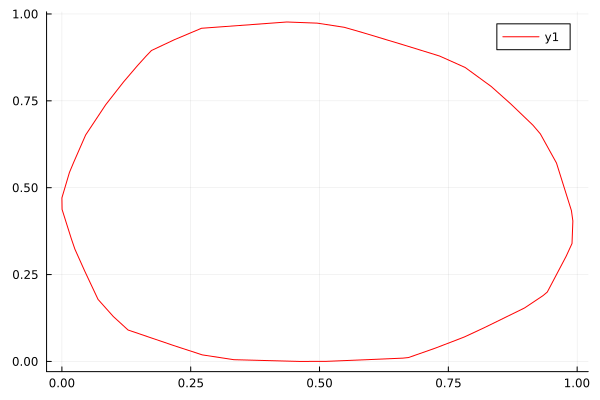

In [30]:
n_vertice = 50
obstacle = GenerateRandomConvexObstacle(n_vertice) #obstacle points
xs = []
ys = []
for i in 1:n_vertice
    append!(xs,obstacle[i].x)
    append!(ys,obstacle[i].y)
end

append!(xs,obstacle[1].x)
append!(ys,obstacle[1].y)

plot(xs,ys, linecolor = :red)

### Convex Test for Polygons

In [31]:
function isConvex(points)
    convex = true
    i = 1
    m_min = 0
    m_max = 0
    prev = 0
    next = 0
    points_aux = []
    k = 1
    while (i <= length(points)) && convex
        prev = (length(points)+i-2)%(length(points))+1
        next = (i)%(length(points))+1

        println("\nPonto atual: ", i, ", Ponto anterior: ", prev, " Ponto seguinte: ", next)

        x_prev = points[prev].x
        x_now = points[i].x
        x_next = points[next].x
        y_prev = points[prev].y
        y_now = points[i].y
        y_next = points[next].y

        println("\nPonto atual: x = ", x_now, ", y = ", y_now, "\n")

        for j in 1:length(points)
            if (j != prev) && (j != next) && (j != i)
                println("O ponto = ", j, " será analisado!")
                push!(points_aux, points[j])
                k += 1
            end
        end
        
        println("\n")

        ang1 = 180*atan((y_prev - y_now)/(x_prev - x_now))/pi
        ang2 = 180*atan((y_next - y_now)/(x_next - x_now))/pi
        
        if (x_prev < x_now)
            ang1 = 180 + ang1
        end
        if (x_next < x_now)
            ang2 = 180 + ang2
        end

        if ang1<ang2 
            ang_min = ang1
            ang_max = ang2
        else
            ang_max = ang1
            ang_min = ang2
        end

        if (signbit(ang_min) != 1 && signbit(ang_max) != 1 && abs(ang_min-ang_max) > 180)
            ang_max = ang_max-360
            ang_aux = ang_min
            ang_min = ang_max
            ang_max = ang_aux
        elseif (signbit(ang_min) && abs(ang_min-ang_max) > 180)
            ang_min = 360 + ang_min
            ang_aux = ang_max
            ang_max = ang_min
            ang_min = ang_aux
        end

            

        println("Ang_min = ", ang_min)
        println("Ang_max = ", ang_max)

        for p in points_aux
            println("\nPonto ", i, ", em relação ao Ponto x = ", p.x, ", y = ", p.y)
            ang = 180*atan((p.y - y_now)/(p.x - x_now))/pi
            if (p.x < x_now)
                ang = 180 + ang
            end
            if (ang < ang_min) || (ang > ang_max)
                if signbit(ang)
                    ang = 360+ang
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        println("Não é convexo, pois ang = ", ang)
                        break
                    end
                else
                    ang = ang-360
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        println("Não é convexo, pois ang = ", ang)
                        break
                    end
                end
            end
            println("Sem problemas de convexidade, pois ang = ", ang)
        end

        points_aux = []

        i += 1
    end   
    return convex
end

isConvex (generic function with 1 method)

In [32]:
isConvex(obstacle)


Ponto atual: 1, Ponto anterior: 50 Ponto seguinte: 2

Ponto atual: x = 0.46136369534324473, y = 0.0

O ponto = 3 será analisado!
O ponto = 4 será analisado!
O ponto = 5 será analisado!
O ponto = 6 será analisado!
O ponto = 7 será analisado!
O ponto = 8 será analisado!
O ponto = 9 será analisado!
O ponto = 10 será analisado!
O ponto = 11 será analisado!
O ponto = 12 será analisado!
O ponto = 13 será analisado!
O ponto = 14 será analisado!
O ponto = 15 será analisado!
O ponto = 16 será analisado!
O ponto = 17 será analisado!
O ponto = 18 será analisado!
O ponto = 19 será analisado!
O ponto = 20 será analisado!
O ponto = 21 será analisado!
O ponto = 22 será analisado!
O ponto = 23 será analisado!
O ponto = 24 será analisado!
O ponto = 25 será analisado!
O ponto = 26 será analisado!
O ponto = 27 será analisado!
O ponto = 28 será analisado!
O ponto = 29 será analisado!
O ponto = 30 será analisado!
O ponto = 31 será analisado!
O ponto = 32 será analisado!
O ponto = 33 será analisado!
O pont

true

### Map Rectangle Dimension

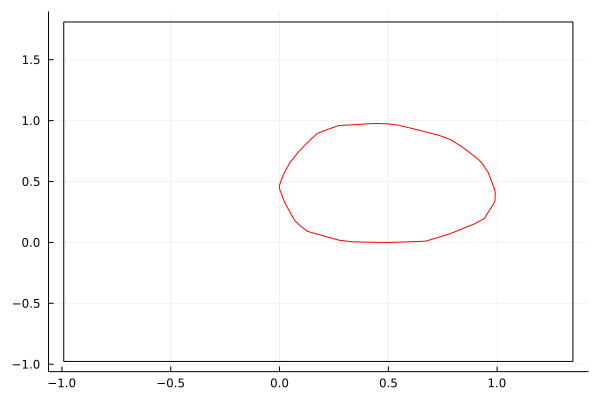

In [44]:
α = rand(1:0.0001:2)
β = rand(1:0.0001:2)

xmax = 0
ymax = 0
for i in 1:n_vertice
    xmax = max(obstacle[i].x, xmax)
    ymax = max(obstacle[i].y, ymax)
end

xmap = zeros(5,1)
ymap = zeros(5,1)

xmap[1:2] .= -xmax
xmap[3:4] .= xmax*α
xmap[5] = xmap[1]
ymap[1] = -ymax
ymap[2:3] .= ymax*β
ymap[4] = -ymax
ymap[5] = ymap[1]

map_points = SVector.(xmap,ymap)

plot!(Tuple.(map_points[:,1]), linecolor = :black, legend = false) 


### Generating Raw Convex Polygons

In [49]:
function findPointInContact(xmax_map, ymax_map, m, x, y, dif_x, dif_y)
    n = y - m*x

    if dif_x > 0
        x_t = -xmax
    else
        x_t = xmax_map
    end
    
    y_f = m*x_t + n

    if y_f > ymax_map || y_f < -ymax
        if dif_y > 0
            ya = -ymax
        else
            ya = ymax_map
        end
        xa = (ya - n)/m
    else
        xa = x_t
        ya = y_f
    end

    p = [xa,ya]
    
    return p
end

findPointInContact (generic function with 1 method)

In [50]:
function GenerateRawConvexPolygons()
    ob = obstacle
    
    m = zeros(n_vertice,2)
    dif_x = zeros(n_vertice,2)
    dif_y = zeros(n_vertice,2)
    for i in 1:n_vertice
        prev = (n_vertice+i-2)%(n_vertice)+1
        next = (i)%(n_vertice)+1
        dif_x[i,1] = ob[prev].x - ob[i].x
        dif_x[i,2] = ob[next].x - ob[i].x
        dif_y[i,1] = ob[prev].y - ob[i].y
        dif_y[i,2] = ob[next].y - ob[i].y
        m[i,1] = dif_y[i,1] / dif_x[i,1]
        m[i,2] = dif_y[i,2] / dif_x[i,2]
        println("----------------")
        println("point ", i, ", x = ",ob[i].x, " and y = ", ob[i].y)
        println("prev angle = ", m[i,1])
        println("next angle = ", m[i,2])
        println("----------------")
    end

    free_area = []

    for i in 1:n_vertice
        p_pol = []
        push!(p_pol,ob[i])
        p_aux = findPointInContact(xmap[3], ymap[3], m[i,1], ob[i].x, ob[i].y, dif_x[i,1], dif_y[i,1])
        push!(p_pol,p_aux)
        p_aux = findPointInContact(xmap[3], ymap[3], m[i,2], ob[i].x, ob[i].y, dif_x[i,2], dif_y[i,2])
        push!(p_pol,p_aux)
        push!(free_area,p_pol)
    end
    return free_area
    
end

GenerateRawConvexPolygons (generic function with 1 method)

In [55]:
area = GenerateRawConvexPolygons()
x_free = zeros(n_vertice,4)
y_free = zeros(n_vertice,4)
for i in 1:n_vertice
    p = area[i]
    for j in 1:3
        x_free[i,j] = p[j,1]
        x_free[i,4] = p[1,1]
        y_free[i,j] = p[j,2]
        y_free[i,4] = p[1,2]
    end
    
end


----------------
point 1, x = 0.46136369534324473 and y = 0.0
prev angle = 0.004811078326344542
next angle = -0.0392343046023264
----------------
----------------
point 2, x = 0.3337741282729141 and y = 0.005005887938516307
prev angle = -0.0392343046023264
next angle = -0.22551390044457745
----------------
----------------
point 3, x = 0.2724062890351029 and y = 0.018845188726890894
prev angle = -0.22551390044457745
next angle = -0.48495885825827467
----------------
----------------
point 4, x = 0.21635740943147264 and y = 0.04602658938612292
prev angle = -0.48495885825827467
next angle = -0.5048687840395861
----------------
----------------
point 5, x = 0.12840053768244297 and y = 0.09043326827398135
prev angle = -0.5048687840395861
next angle = -1.3569474656460172
----------------
----------------
point 6, x = 0.09970332756279365 and y = 0.12937387481695073
prev angle = -1.3569474656460172
next angle = -1.6618134369159707
----------------
----------------
point 7, x = 0.0701934668128

LoadError: MethodError: [0mCannot `convert` an object of type [92mSVector{2, Float64}[39m[0m to an object of type [91mFloat64[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Gray24[39m) where T<:Real at C:\Users\jpbru\.julia\packages\ColorTypes\1dGw6\src\conversions.jl:114
[0m  convert(::Type{T}, [91m::Gray[39m) where T<:Real at C:\Users\jpbru\.julia\packages\ColorTypes\1dGw6\src\conversions.jl:113
[0m  convert(::Type{T}, [91m::T[39m) where T<:Number at number.jl:6
[0m  ...

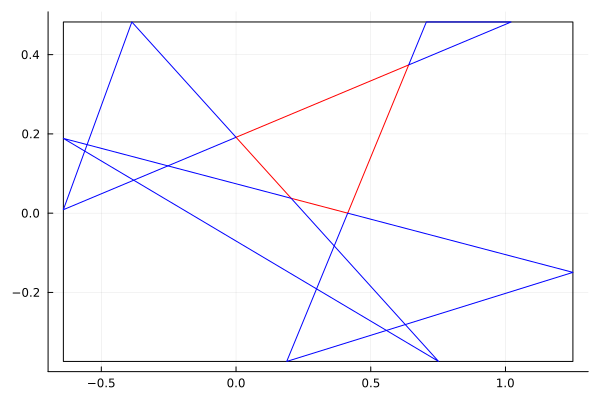

In [ ]:
for i in 1:n_vertice-1
    plot!(x_free[i,:],y_free[i,:], linecolor = :blue)
end

plot!(x_free[n_vertice,:],y_free[n_vertice,:], linecolor = :blue, legend = false)

In [ ]:
inside = [inpolygon([1 2], map_points; in=true, on=false, out=false)]

LoadError: MethodError: no method matching getindex(::Point, ::Int64)